In [10]:
# Download and load MovieLens 100k dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# Load ratings
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings.head()


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
# Load movie info
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1')
movies.head()

,1,Toy Story (1995),01-Jan-1995,Unnamed: 3,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0.1,0.2,1.1,1.2,...,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15
0,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Load genres
genres = pd.read_csv('ml-100k/u.genre', sep='|', names=['genre', 'genre_id'], encoding='latin-1')
genres.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [14]:
# Feature engineering: average rating, number of ratings, one-hot encoded genres
# Set column names for movies
movie_columns = ['movie_id', 'movie_title'] + [f'genre_{g}' for g in genres['genre']] + ['release_date', 'video_release_date', 'IMDb_URL'] + [f'unknown_{i}' for i in range(19-len(genres))]
movies.columns = movie_columns[:len(movies.columns)]

# Calculate average rating and number of ratings per movie
movie_stats = ratings.groupby('movie_id').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']
movie_stats.reset_index(inplace=True)

# Merge with genre columns
genre_cols = [col for col in movies.columns if col.startswith('genre_')]
movie_features = movies[['movie_id', 'movie_title'] + genre_cols].merge(movie_stats, on='movie_id')
movie_features = movie_features.fillna(0)

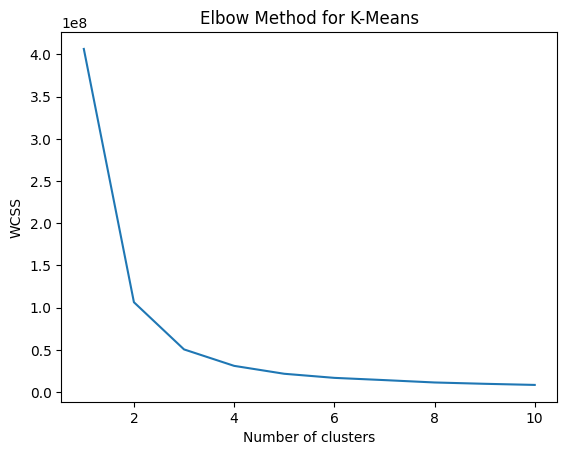

In [19]:
# K-Means clustering and Elbow method
# Select only numeric columns for clustering
X = movie_features.select_dtypes(include=[np.number])
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


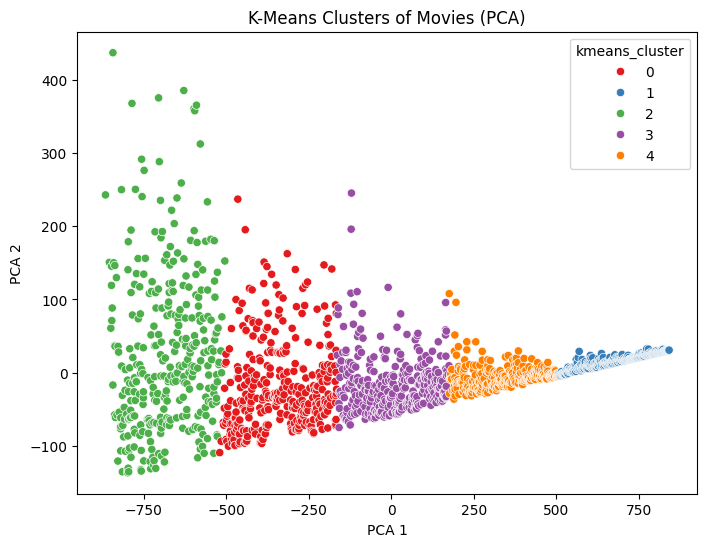

In [20]:
# Fit KMeans with optimal k (e.g., k=5)
kmeans = KMeans(n_clusters=5, random_state=42)
movie_features['kmeans_cluster'] = kmeans.fit_predict(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=movie_features['kmeans_cluster'], palette='Set1', legend='full')
plt.title('K-Means Clusters of Movies (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

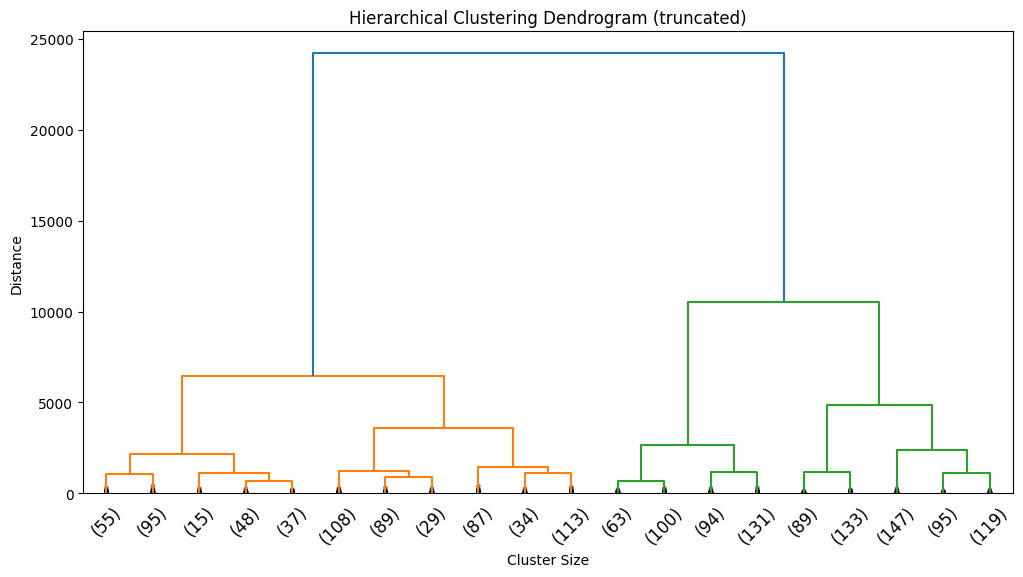

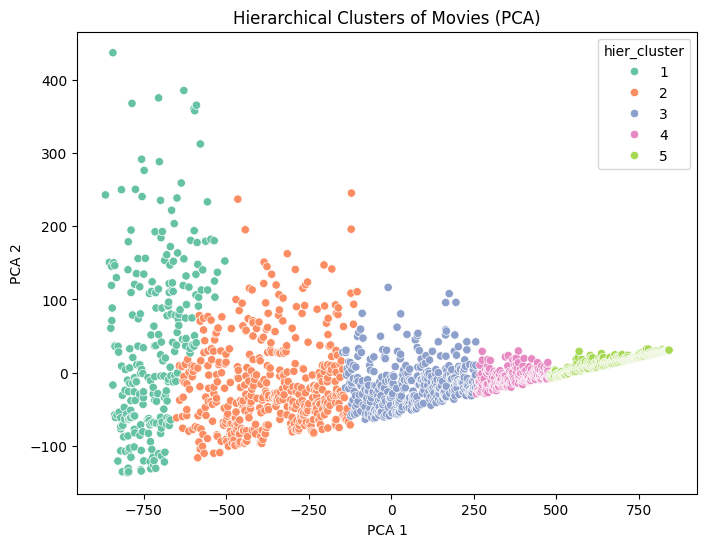

In [21]:
# Hierarchical Clustering and Dendrogram
linked = linkage(X, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

# Assign clusters (e.g., k=5)
movie_features['hier_cluster'] = fcluster(linked, 5, criterion='maxclust')

# PCA for visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=movie_features['hier_cluster'], palette='Set2', legend='full')
plt.title('Hierarchical Clusters of Movies (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()